In [2]:
# Installing required packages
!pip install transformers sentencepiece > /dev/null 2>&1

In [3]:
# Importing packages
import pandas as pd
import re
import glob
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import MT5Tokenizer
from google.colab import drive
import matplotlib.pyplot as plt

In [5]:
# Mouting Google Drive to the current Colab session for accessing files stored in the Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed.csv to preprocessed (1).csv


In [25]:
# Initializing an empty DataFrame to compile all data entries
aggregated_data = pd.DataFrame(columns=["text", "tags"])

In [26]:
import pandas as pd
data = pd.read_csv('/content/preprocessed.csv')
data.head()

,id,url,source,title,text,catagory,tags,word_count,language
0,59,http://t.me/tikvahethiopia,telegram,NaN,"🇪🇹 የፖለቲካ ፓርቲዎች ምን ይላሉ ? 🇪🇹\n\n"" ግጭቶች ከትንሽ ነገር ...",news,"#በነፃነት_ተንቀሳቅሰን,#መካከለኛ_ገቢ,#አባላትን_አፍርቻለሁ,#Tikvah...",576,am
1,130,http://t.me/tikvahethiopia,telegram,NaN,"🇪🇹 የፖለቲካ ፓርቲዎች ምን ይላሉ ? 🇪🇹\n\n"" ... አሁንም ቢሆን ለ...",news,"#ኦፌኮ,#ከመገዳደል,#መደራደር,#ግድያ,#እስራት,#ብልሹ_አሰራርና,#ሙስና...",462,am
2,241,http://t.me/tikvahethiopia,telegram,NaN,""" በ5ቱ ኮሪደር ልማት ስራ 16 ሺህ ሰዎች የስራ እድል ተፈጥሮላቸዋል ""...",news,NaN,145,am
3,897,http://t.me/tikvahethiopia,telegram,NaN,#Update\n\nኦክሎክ ሞተርስ “ስሜን አጥፍቷል” ላለው ቱሪስት ታክሲ ...,news,"#Update,#ከሄሎ_ታክሲ,#እየሸጠ_ነው",186,am
4,1308,http://t.me/tikvahethiopia,telegram,NaN,#ደሴ\n\n“ አንድ ቀን ውሳኔ ተሰጥቶባቸው ከአካባቢ ብክለት ነፃ እንዲሆ...,news,"#ደሴ,#ቪዲዮም,#ከህዝብ_መኖሪያ,#ሞዲፋይ,#TikvahFamilyAddisA...",408,am


In [27]:
df = data[["text", "tags"]].rename(columns={"text":"text", "tags":"tags"}) # Renaming columns: text--> text, tags --> tags (to have consistent column names)

print(df.head())
aggregated_data = pd.concat([aggregated_data, df], ignore_index=True) # Adding to the aggregation dataframe

                                                text  \
0  🇪🇹 የፖለቲካ ፓርቲዎች ምን ይላሉ ? 🇪🇹\n\n" ግጭቶች ከትንሽ ነገር ...   
1  🇪🇹 የፖለቲካ ፓርቲዎች ምን ይላሉ ? 🇪🇹\n\n" ... አሁንም ቢሆን ለ...   
2  " በ5ቱ ኮሪደር ልማት ስራ 16 ሺህ ሰዎች የስራ እድል ተፈጥሮላቸዋል "...   
3  #Update\n\nኦክሎክ ሞተርስ “ስሜን አጥፍቷል” ላለው ቱሪስት ታክሲ ...   
4  #ደሴ\n\n“ አንድ ቀን ውሳኔ ተሰጥቶባቸው ከአካባቢ ብክለት ነፃ እንዲሆ...   

                                                tags  
0  #በነፃነት_ተንቀሳቅሰን,#መካከለኛ_ገቢ,#አባላትን_አፍርቻለሁ,#Tikvah...  
1  #ኦፌኮ,#ከመገዳደል,#መደራደር,#ግድያ,#እስራት,#ብልሹ_አሰራርና,#ሙስና...  
2                                                NaN  
3                          #Update,#ከሄሎ_ታክሲ,#እየሸጠ_ነው  
4  #ደሴ,#ቪዲዮም,#ከህዝብ_መኖሪያ,#ሞዲፋይ,#TikvahFamilyAddisA...  


In [28]:
print("Current Number of Entries: ", aggregated_data.shape[0]) # 12010

Current Number of Entries:  12010


In [29]:
# Remove duplicates based on 'text' and 'summary' columns
aggregated_data.drop_duplicates(subset=['text', 'tags'], inplace=True)

duplicate_count = aggregated_data.duplicated(subset=['text', 'tags']).sum()
print(f"Number of duplicate rows: {duplicate_count}") # There doesn't seem to be any duplicates

Number of duplicate rows: 0


In [30]:
# Removing any NaN (incomplete) entries
aggregated_data.describe()

,text,tags
count,11889,6128
unique,11889,4250
top,"🇪🇹 የፖለቲካ ፓርቲዎች ምን ይላሉ ? 🇪🇹\n\n"" ግጭቶች ከትንሽ ነገር ...",#update
freq,1,1007


In [33]:
aggregated_data.isna().sum()

text              0
tags           5761
text_length       0
dtype: int64

In [34]:
# Removing any NaN (incomplete) entries
aggregated_data = aggregated_data.dropna(subset=['text', 'tags'])

In [35]:
aggregated_data.head()

,text,tags,text_length
0,"🇪🇹 የፖለቲካ ፓርቲዎች ምን ይላሉ ? 🇪🇹\n\n"" ግጭቶች ከትንሽ ነገር ...","#በነፃነት_ተንቀሳቅሰን,#መካከለኛ_ገቢ,#አባላትን_አፍርቻለሁ,#Tikvah...",2947
1,"🇪🇹 የፖለቲካ ፓርቲዎች ምን ይላሉ ? 🇪🇹\n\n"" ... አሁንም ቢሆን ለ...","#ኦፌኮ,#ከመገዳደል,#መደራደር,#ግድያ,#እስራት,#ብልሹ_አሰራርና,#ሙስና...",2295
3,#Update\n\nኦክሎክ ሞተርስ “ስሜን አጥፍቷል” ላለው ቱሪስት ታክሲ ...,"#Update,#ከሄሎ_ታክሲ,#እየሸጠ_ነው",926
4,#ደሴ\n\n“ አንድ ቀን ውሳኔ ተሰጥቶባቸው ከአካባቢ ብክለት ነፃ እንዲሆ...,"#ደሴ,#ቪዲዮም,#ከህዝብ_መኖሪያ,#ሞዲፋይ,#TikvahFamilyAddisA...",1964
5,"#Update\n\n"" 4 ሚሊዮን ብር ለማስለቀቂያ ከፍለናል ሰነዱ በእጄ አ...","#Update,#የቀን_ሰራተኞች,#ተቀበሉን,#የከፈልናቸው,#መክፈላቸውንና,#...",2746


In [36]:
# Looking at the number of tokens
# Using mT5's tokenizer to find the number of tokens
tokenizer = MT5Tokenizer.from_pretrained('google/mt5-small')

def count_tokens(text, tokenizer):
    '''
    Count the number of tokens in a given text using a specified tokenizer.

    Args:
        text (str): The text to be tokenized.
        tokenizer: The tokenizer to be used for tokenizing the text.

    Returns:
        int: The total number of tokens in the tokenized text.
    '''

    # Encoding the text using the tokenizer
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # Returning the number of tokens
    return len(tokens)

In [38]:
# Statistical analysis of the dataset
aggregated_data['text_length'] = aggregated_data['text'].apply(len)
aggregated_data['tags_length'] = aggregated_data['tags'].apply(len)

# Word counts
aggregated_data['text_word_count'] = aggregated_data['text'].apply(lambda x: len(x.split()))
aggregated_data['summary_word_count'] = aggregated_data['tags'].apply(lambda x: len(x.split()))

# Token counts
aggregated_data['text_token_count'] = aggregated_data['text'].apply(lambda x: count_tokens(x, tokenizer))
aggregated_data['tags_token_count'] = aggregated_data['tags'].apply(lambda x: count_tokens(x, tokenizer))

# Descriptive statistics
print(aggregated_data[['text_length', 'tags_length', 'text_word_count', 'text_token_count', 'tags_token_count']].describe())

# Counting most common words
all_words = ' '.join(aggregated_data['text']).split()
word_counts = Counter(all_words)
print("Most common words: ", word_counts.most_common(10))


       text_length  tags_length  text_word_count  text_token_count  \
count  6128.000000  6128.000000      6128.000000       6128.000000   
mean    569.178198    18.575881       103.274315        350.450392   
std     598.041810    17.621562       116.321960        376.380045   
min      13.000000     2.000000         1.000000          8.000000   
25%     197.000000     7.000000        32.000000        115.000000   
50%     353.000000    13.000000        61.000000        213.000000   
75%     685.250000    23.000000       124.000000        427.000000   
max    4096.000000   205.000000       849.000000       2634.000000   

       tags_token_count  
count       6128.000000  
mean          12.400131  
std           11.897013  
min            2.000000  
25%            5.000000  
50%            9.000000  
75%           16.000000  
max          155.000000  
Most common words:  [('እና', 6560), ('ላይ', 6216), ('@tikvahethiopia', 5753), ('@tsegabwolde', 5585), ('ወደ', 3210), ('ነው', 3111), ('አቶ', 

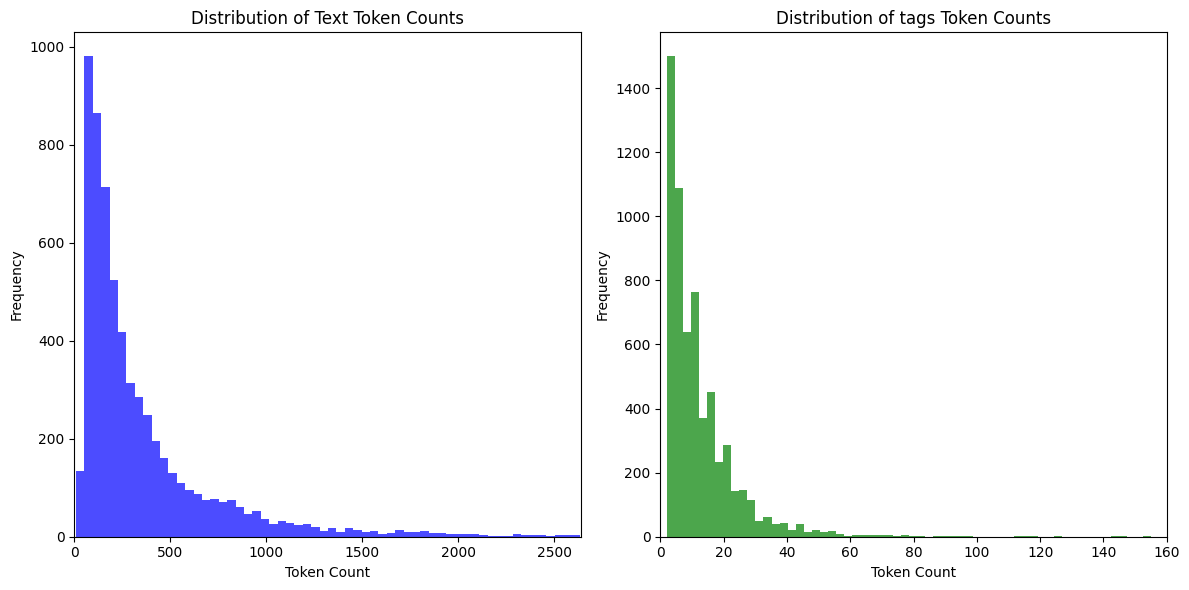

In [39]:
# Visualizing the distribution of the token counts for both the texts and summaries

# Extracting token counts
text_token_counts = aggregated_data['text_token_count']
tags_token_counts = aggregated_data['tags_token_count']

# Determining the upper limit for the x-axis
upper_limit_text = max(text_token_counts) + 5
upper_limit_summary = max(tags_token_counts) + 5

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for text token counts
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(text_token_counts, bins=60, color='blue', alpha=0.7)
plt.title('Distribution of Text Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.xlim(0, upper_limit_text)

# Histogram for summary token counts
plt.subplot(1, 2, 2)
plt.hist(tags_token_counts, bins=60, color='green', alpha=0.7)
plt.title('Distribution of tags Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.xlim(0, upper_limit_summary)

# Show the plots
plt.tight_layout()
plt.show()

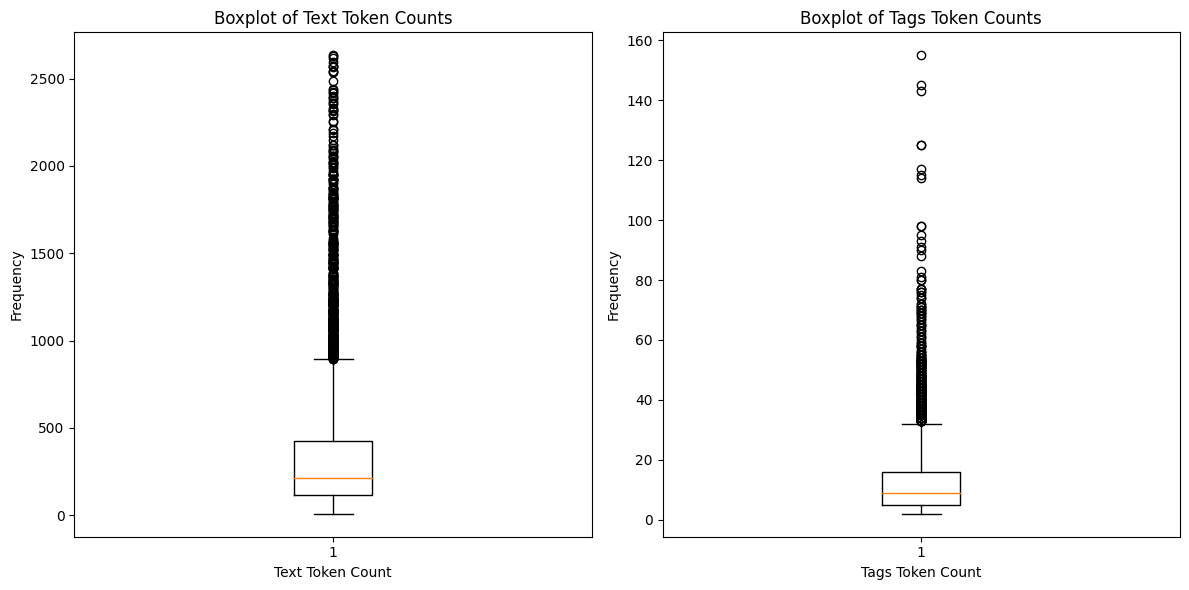

In [40]:
# Plotting boxplots
plt.figure(figsize=(12, 6))

# Boxplot for text token counts
plt.subplot(1, 2, 1)
plt.boxplot(text_token_counts)
plt.title('Boxplot of Text Token Counts')
plt.xlabel('Text Token Count')
plt.ylabel('Frequency')

# Boxplot for summary token counts
plt.subplot(1, 2, 2)
plt.boxplot(tags_token_counts)
plt.title('Boxplot of Tags Token Counts')
plt.xlabel('Tags Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [42]:
# Saving Amharic

# Splitting the dataset
# 80% training, 10% validation, 10% testing
train, temp = train_test_split(aggregated_data, test_size=0.20, random_state=16)
valid, test = train_test_split(temp, test_size=0.50, random_state=16)

# Save them to different CSVs
train.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_train.csv', index=False)
valid.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_valid.csv', index=False)
test.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_test.csv', index=False)

# Also saving everything to one file to make it available together
aggregated_data.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_1_all.csv', index=False)

In [43]:
# Load each Amharic dataset from CSV
# All of these files were saved to the same directory all the raw data files are saved and made available
# The path can be updated to wherever these datafiles are stored if that has changed
train_df = pd.read_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_train.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_valid.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_test.csv')

# Concatenate them back into one DataFrame
aggregated_data_further_cleaned = pd.concat([train_df, valid_df, test_df], ignore_index=True)

In [44]:
# Creating Normalized Data

def normalize_char_level_missmatch(input_token):
  '''
    Normalize variations of Amharic characters in a given token to standardize them.

    Args:
        input_token (str): The Amharic token to be normalized.

    Returns:
        str: The normalized Amharic token.
  '''

  rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
  rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
  rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
  rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
  rep5=re.sub('[ሕኅ]','ህ',rep4)
  rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
  rep7=re.sub('[ሠ]','ሰ',rep6)
  rep8=re.sub('[ሡ]','ሱ',rep7)
  rep9=re.sub('[ሢ]','ሲ',rep8)
  rep10=re.sub('[ሣ]','ሳ',rep9)
  rep11=re.sub('[ሤ]','ሴ',rep10)
  rep12=re.sub('[ሥ]','ስ',rep11)
  rep13=re.sub('[ሦ]','ሶ',rep12)
  rep14=re.sub('[ዓኣዐ]','አ',rep13)
  rep15=re.sub('[ዑ]','ኡ',rep14)
  rep16=re.sub('[ዒ]','ኢ',rep15)
  rep17=re.sub('[ዔ]','ኤ',rep16)
  rep18=re.sub('[ዕ]','እ',rep17)
  rep19=re.sub('[ዖ]','ኦ',rep18)
  rep20=re.sub('[ጸ]','ፀ',rep19)
  rep21=re.sub('[ጹ]','ፁ',rep20)
  rep22=re.sub('[ጺ]','ፂ',rep21)
  rep23=re.sub('[ጻ]','ፃ',rep22)
  rep24=re.sub('[ጼ]','ፄ',rep23)
  rep25=re.sub('[ጽ]','ፅ',rep24)
  rep26=re.sub('[ጾ]','ፆ',rep25)

  #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል
  rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
  rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
  rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
  rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
  rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
  rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
  rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
  rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
  rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
  rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
  rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
  rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
  rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
  rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
  rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
  rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
  rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
  rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
  rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
  rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
  rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
  rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ
  return rep48

# :: No longer removed
def remove_punc_and_special_chars(text):
  '''
    Remove punctuation and special characters from a given text.

    Args:
        text (str): The text from which to remove punctuation and special characters.

    Returns:
        str: The text stripped of punctuation and special characters.
  '''

  normalized_text = re.sub('[\!\@\#\$\%\^\«\»\&\*\(\)\…\[\]\{\}\;\“\”\›\’\‘\"\'\:\,\.\‹\/\<\>\?\\\\|\`\´\~\-\=\+\፡\፤\;\፦\፥\፧\፨\፠\፣]', '',text)
  return normalized_text

# Remove all ascii characters
def remove_ascii_and_numbers(text_input):
  '''
    Remove ASCII characters and numbers from the given text.

    Args:
        text_input (str): The text from which to remove ASCII characters and numbers.

    Returns:
        str: The text without any ASCII characters and numbers.
  '''

  return re.sub('[A-Za-z]','',text_input)

In [45]:
# Normalizing the text and tags columns using the three normalization functions
aggregated_data_further_cleaned['text'] = aggregated_data_further_cleaned['text'].apply(
    lambda x: remove_ascii_and_numbers(
        remove_punc_and_special_chars(
            normalize_char_level_missmatch(x))))

aggregated_data_further_cleaned['tags'] = aggregated_data_further_cleaned['tags'].apply(
    lambda x: remove_ascii_and_numbers(
        remove_punc_and_special_chars(
            normalize_char_level_missmatch(x))))

# Updating the statistical columns following the normalization steps
# Length of the text and tags
aggregated_data_further_cleaned['text_length'] = aggregated_data_further_cleaned['text'].apply(len)
aggregated_data_further_cleaned['tags_length'] = aggregated_data_further_cleaned['tags'].apply(len)

# Word count in the text and tags
aggregated_data_further_cleaned['text_word_count'] = aggregated_data_further_cleaned['text'].apply(lambda x: len(x.split()))
aggregated_data_further_cleaned['tags_word_count'] = aggregated_data_further_cleaned['tags'].apply(lambda x: len(x.split()))

# Token count in the text and tags
aggregated_data_further_cleaned['text_token_count'] = aggregated_data_further_cleaned['text'].apply(lambda x: count_tokens(x, tokenizer))
aggregated_data_further_cleaned['tags_token_count'] = aggregated_data_further_cleaned['tags'].apply(lambda x: count_tokens(x, tokenizer))

# Showing descriptive statistics of the token counts
aggregated_data_further_cleaned[['text_token_count', 'tags_token_count']].describe()

,text_token_count,tags_token_count
count,6128.000000,6128.000000
mean,325.665307,9.074739
std,363.851236,9.919027
min,1.000000,1.000000
25%,97.000000,1.000000
50%,194.000000,7.000000
75%,403.000000,12.000000
max,2570.000000,135.000000


In [48]:
# Setting the thresholds for Amharic

max_text_token_count = 512
max_summary_word_count = 128

# Applying the filters
bounded_token_length_aggregated_data_further_cleaned = aggregated_data_further_cleaned[
    (aggregated_data_further_cleaned['text_token_count'] <= max_text_token_count) &
    (aggregated_data_further_cleaned['tags_token_count'] <= max_summary_word_count)
]

# Displaying the first few rows of the filtered DataFrame
print(bounded_token_length_aggregated_data_further_cleaned.head())

                                                text  \
0   የጣሊያን መከላከያ ሚኒስትር ኤልዛቤታ ቴራንታ በኢትዮጵያ ይፋዊ የስራ ጉ...   
1   የጠቅላይ ሚኒስትር ቃል አቀባይ ፅቤት ሀላፊ የነበሩትን አቶ ፍፁም_አረጋ...   
2  አልሸባብ‼️\n\nአልሸባብ በሶማሊያ አወዛጋቢው ምሁር የሚባለዉን ግለሰብና...   
4  በአፍሪካ ህብረት አዳራሽ እንገናኝ\nከምሽቱ 1200 ጀምሮ\n\nውድ የሀዋ...   
5   ሱዳንና ኤርትራ ግንኙነታቸውን ሊያድሱ ነው። ባለፈው አመት ሱዳን በኳታር...   

                                tags  text_length  tags_length  \
0                                             351            0   
1           ፍፁም_አረጋንሽመልስ_አብዲሳህይወታቸውን          218           24   
2                   ገደለአብዲያሲስ_አቡ_ሙሳብ          507           16   
4  የሀዋሳ_ዩኒቨርሲቲየጥላቻ_ንግግርአመራሮችተሳታፊአባላት          322           33   
5                                             234            0   

   text_word_count  summary_word_count  text_token_count  tags_token_count  \
0               62                   1               231                 1   
1               42                   1               142                19   
2               91              

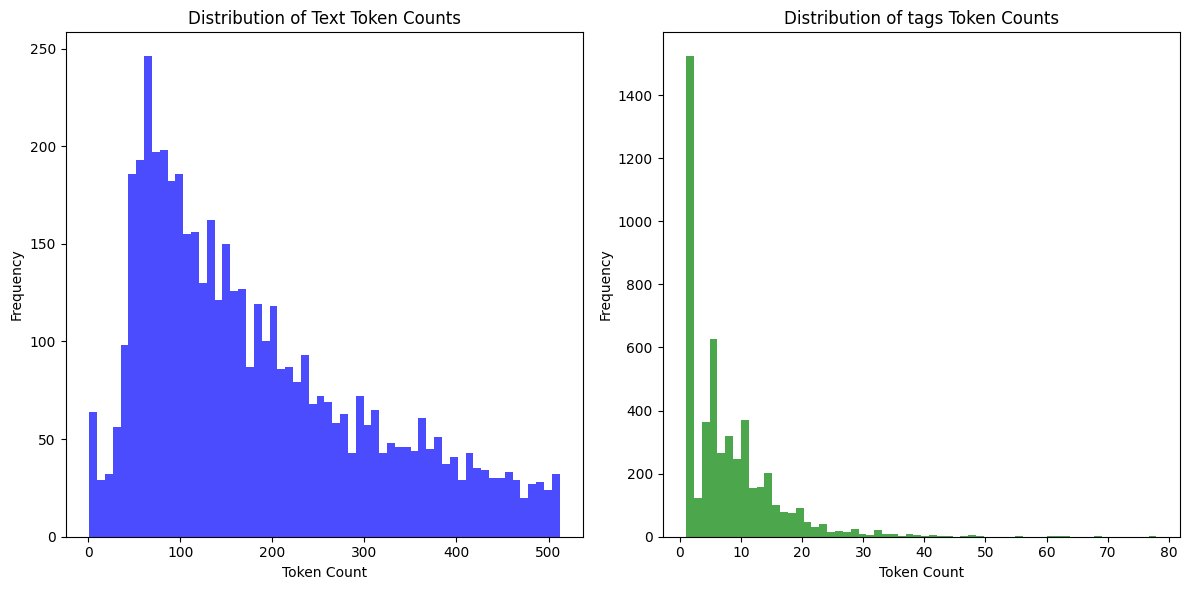

In [50]:
# Extracting token counts
text_token_counts = bounded_token_length_aggregated_data_further_cleaned['text_token_count']
tags_token_counts = bounded_token_length_aggregated_data_further_cleaned['tags_token_count']

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for text token counts
plt.subplot(1, 2, 1)
plt.hist(text_token_counts, bins=60, color='blue', alpha=0.7)
plt.title('Distribution of Text Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

# Histogram for summary token counts
plt.subplot(1, 2, 2)
plt.hist(tags_token_counts, bins=60, color='green', alpha=0.7)
plt.title('Distribution of tags Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

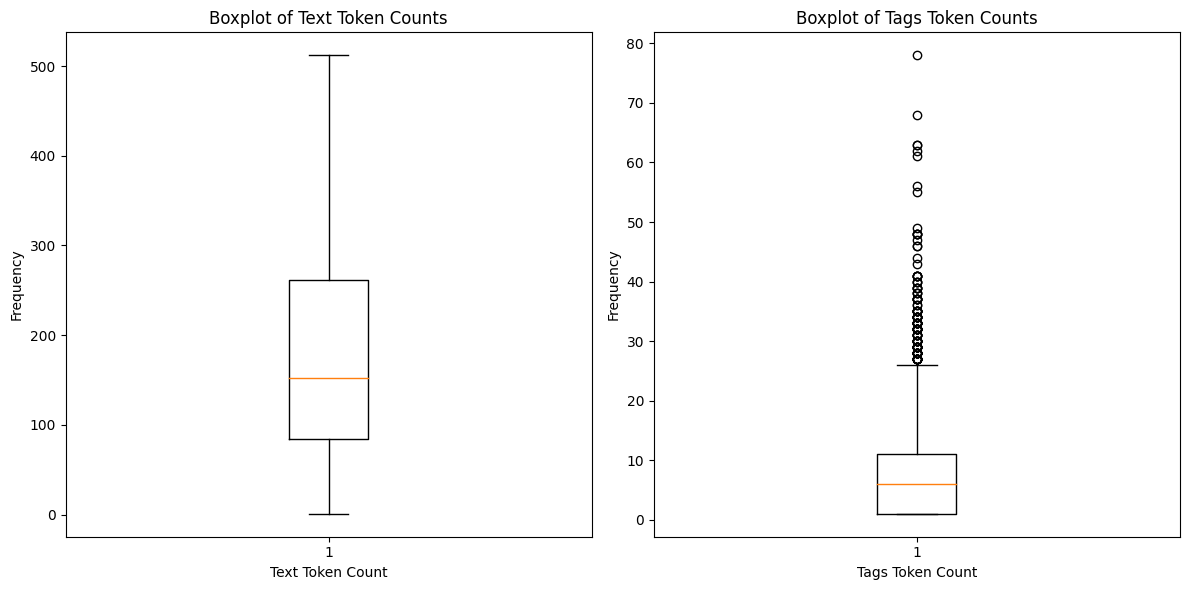

In [51]:
# Plotting boxplots
plt.figure(figsize=(12, 6))

# Boxplot for text token counts
plt.subplot(1, 2, 1)
plt.boxplot(text_token_counts)
plt.title('Boxplot of Text Token Counts')
plt.xlabel('Text Token Count')
plt.ylabel('Frequency')

# Boxplot for summary token counts
plt.subplot(1, 2, 2)
plt.boxplot(tags_token_counts)
plt.title('Boxplot of Tags Token Counts')
plt.xlabel('Tags Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [52]:
# Saving Amharic

# Splitting the dataset
# 80% training, 10% validation, 10% testing
train, temp = train_test_split(bounded_token_length_aggregated_data_further_cleaned, test_size=0.20, random_state=16)
valid, test = train_test_split(temp, test_size=0.50, random_state=16)

# Save them to different CSVs
train.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_train.csv', index=False)
valid.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_valid.csv', index=False)
test.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_test.csv', index=False)

# All of it in the same file
bounded_token_length_aggregated_data_further_cleaned.to_csv('/content/drive/MyDrive/Ahmaric_data' + 'amharic_3_all.csv', index=False)